In [3]:
import scanpy as sc #for scanpy >= 1.3.7
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors


import seaborn as sb
#from gprofiler import GProfiler

#import rpy2.rinterface_lib.callbacks
import logging


#from rpy2.robjects import pandas2ri
#import anndata2ri

In [46]:
#Note: this can be commented out to get more verbose R output
#rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
#pandas2ri.activate()

#anndata2ri.activate()
#%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all seaborn plots. You can set the context as well to 'talk' or 'paper'.

In [38]:
sc.settings.verbosity = 3

In [47]:
sb.set_context(context='poster')

In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(DropletUtils)

# Read data

The dataset consists of 4k PBMCs (Human) provided by 10X Genomics. The data is an mtx directory with an `mtx` file (*i.e.* count matrix), two `tsv` files with barcodes (*i.e.* cell indices) and features (*i.e.* gene symbols). `Scanpy` unpacks the files (if the files are in `gz` archive format) and creates an `anndata` object with the `read_10x_mtx` function.    

The dataset is not filtered, yet. 

In [48]:
file_path_raw = '/Users/yzhiyuan/workspace/scanpy_test/data/raw_gene_bc_matrices/'

In [73]:
adata_raw = sc.read_10x_mtx(path=file_path_raw)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Let us check the dataset size. 

In [74]:
raw = adata_raw
adata_raw.shape

(737280, 33694)

In [9]:
print('Total number of observations: {:d}'.format(adata_raw.n_obs))

Total number of observations: 737280


# Pre-processing and visualization

## Remove empty droplets

The dataset contains an excessive amount of "cells", which are in fact empty droplets. Let us remove these barcodes prior to further quality control. We use emptyDrops to compute if a cell is a cell or an empty droplet.

It must be noted that CellRanger 3.0 has incorporated the EmptyDrops algorithm to distinguish cells from empty droplets.

Prepare input for EmptyDrops.

In [10]:
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

Run EmptyDrops.

In [11]:
# %%R -i sparse_mat -i genes -i barcodes -o barcodes_filtered -o ambient_genes

# sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
# rownames(sce) <- genes 
# ambient <- emptyDrops(counts(sce))
# is_cell <- ambient$FDR <= 0.05
# threshold_ambient <- 0.005
# ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
# barcodes_filtered <- barcodes[which(is_cell)]

UsageError: Cell magic `%%R` not found.


In [11]:
ambient_genes

array(['RPL11', 'RPS27', 'RPS27A', 'TMSB10', 'RPL32', 'RPL34', 'RPS3A',
       'RPS14', 'HLA-B', 'RPS18', 'EEF1A1', 'RPS12', 'ACTB', 'TMSB4X',
       'RPL10', 'RPL7', 'RPS6', 'RPLP2', 'FTH1', 'MALAT1', 'RPS3',
       'RPL41', 'RPL21', 'RPS29', 'B2M', 'RPLP1', 'RPS2', 'RPS15A',
       'RPL13', 'RPL19', 'RPL18A', 'RPS19', 'FTL', 'RPL13A', 'RPL3',
       'MT-CO1', 'MT-CO3'], dtype='<U6')

In [12]:
barcodes_filtered

array(['AAACCTGAGAAGGCCT-1', 'AAACCTGAGACAGACC-1', 'AAACCTGAGATAGTCA-1',
       ..., 'TTTGTCACAGGTCCAC-1', 'TTTGTCAGTTAAGACA-1',
       'TTTGTCATCCCAAGAT-1'], dtype='<U18')

Let us create a filtered data matrix using the filtered barcodes.

In [13]:
adata = adata_raw[np.in1d(adata_raw.obs_names, barcodes_filtered)].copy()

In [75]:
adata = adata_raw

In [79]:
adata_raw

AnnData object with n_obs × n_vars = 4299 × 17038 
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells'

Further analysis: Examine the level of background gene expression (not shown).

## Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

We start with calculating the QC covariates: 

* total number of counts per cell
* number of expressed genes per cell
* fraction of mitochondrial reads per cell

Note: mitochondrial genes in human start with 'MT-'

In [77]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_cells(adata, min_counts=1500)

filtered out 16656 genes that are detectedin less than 3 cells
filtered out 732551 cells that haveless than 250 genes expressed
filtered out 430 cells that haveless than 1500 counts


In [78]:
adata

AnnData object with n_obs × n_vars = 4299 × 17038 
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [16]:
adata.var_names

Index(['RP11-34P13.7', 'FO538757.2', 'AP006222.2', 'RP4-669L17.10',
       'RP11-206L10.9', 'LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17',
       ...
       'MT-ND6', 'MT-CYB', 'BX004987.4', 'AC145212.2', 'AC011043.1',
       'AL592183.1', 'AC007325.4', 'AL354822.1', 'AC004556.1', 'AC240274.1'],
      dtype='object', length=17038)

In [17]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

Let us visualize the number of expressed genes and the number of counts as a scatter plot. 

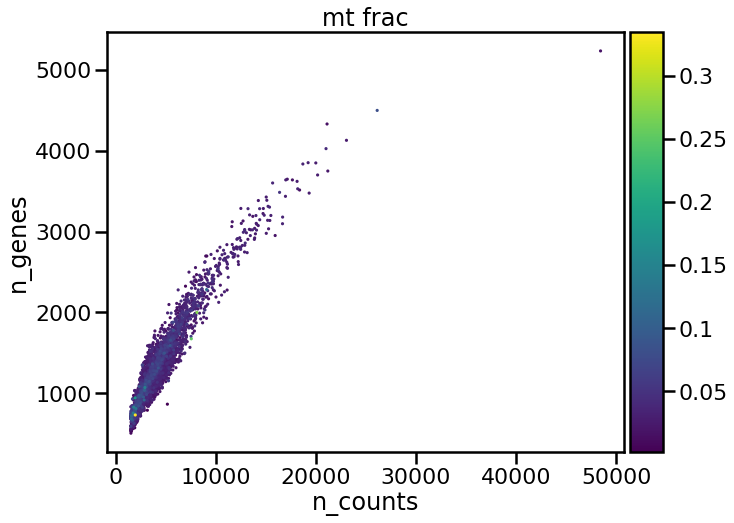

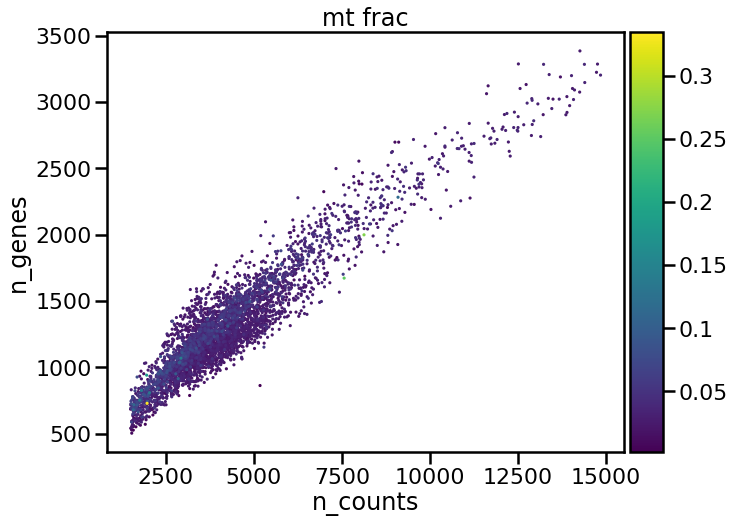

In [18]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=40)
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<15000], 'n_counts', 'n_genes', 
                   color='mt_frac', size=40)

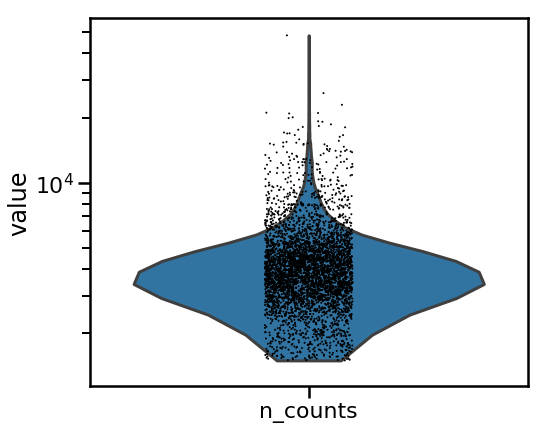

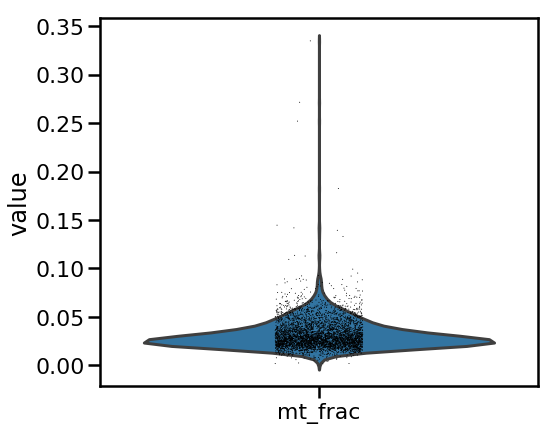

In [19]:
#Sample quality plots
rcParams['figure.figsize']=(7,7)
t1 = sc.pl.violin(adata, 'n_counts',
                  #groupby='sample',
                  size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly.  We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.

Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

Create a histogram for the total number of counts. Further, create a histogram for the low count and high count regime, each.

In [18]:
#Note: pandas does some histogram plotting with adata.obs['n_counts'].hist()
# Nicer plots with seaborn distplot    

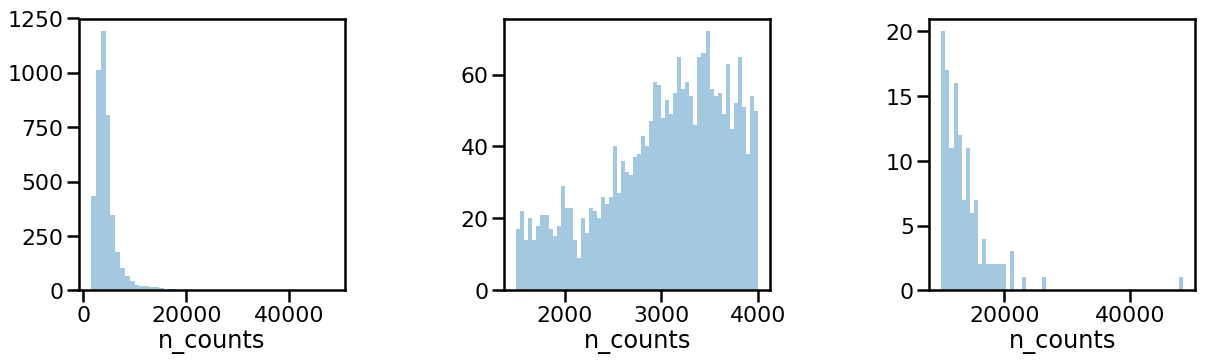

In [20]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

Histograms of the number of counts per cell show a small peak of groups of cells with fewer than 1000 counts, which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts with decaying slope at 15,000 counts. We estimate this population to range until 20,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

Create a histogram for the total number of genes. Further, create a histogram for the low gene count and high gene count regime, each.

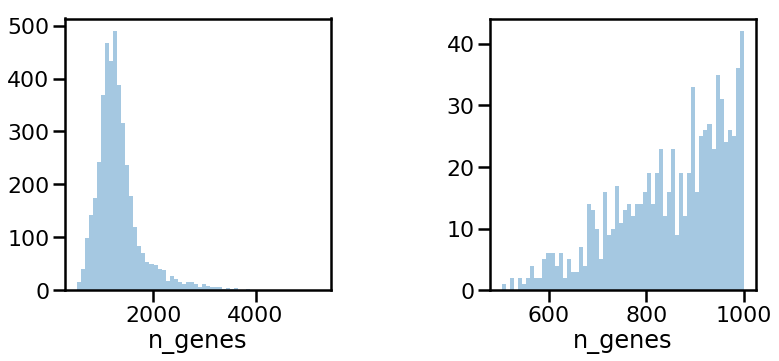

In [21]:
#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

Create a histogram for the fraction of mitochondrial genes. Further, create a histogram for the high fraction regime, each.

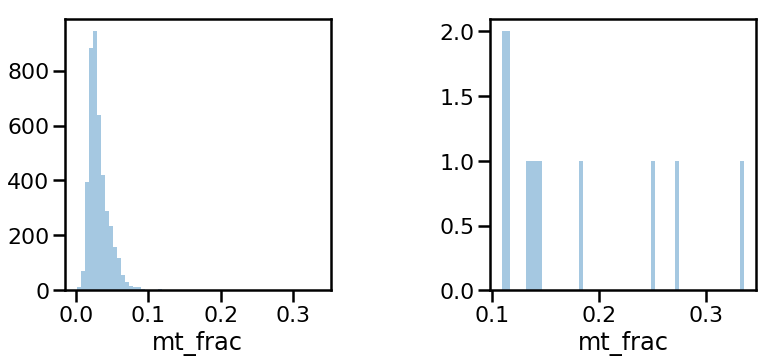

In [22]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.1], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [23]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 4299
Number of cells after min count filter: 4299
filtered out 7 cells that havemore than 20000 counts
Number of cells after max count filter: 4292
Number of cells after MT filter: 4289
filtered out 99 cells that haveless than 700 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 4190


Next, filter out non-expressed genes. Check the number of remaining genes after filtering.

In [23]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33694
filtered out 21474 genes that are detected in less than 20 cells
Number of genes after cell filter: 12220


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset.

## Normalization

So far, our dataset is a count matrix. Here, every count corresponds to an mRNA molecule captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Several methods for normalization for scRNA-seq data have been proposed. Here, we the `scran` library size normalization followed by log-transformation. In addition, we save the count matrix to `layers` as 'counts'.

In [54]:
adata.layers['counts'] = adata.X.copy()

In [80]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [25]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [26]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [27]:
# %%R -i data_mat -i input_groups -o size_factors

# size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

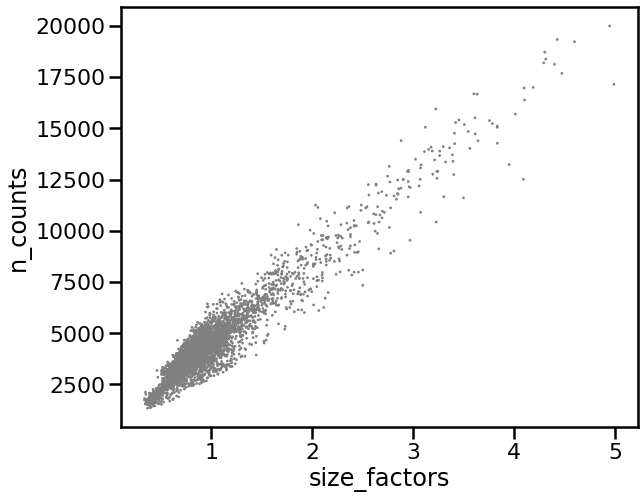

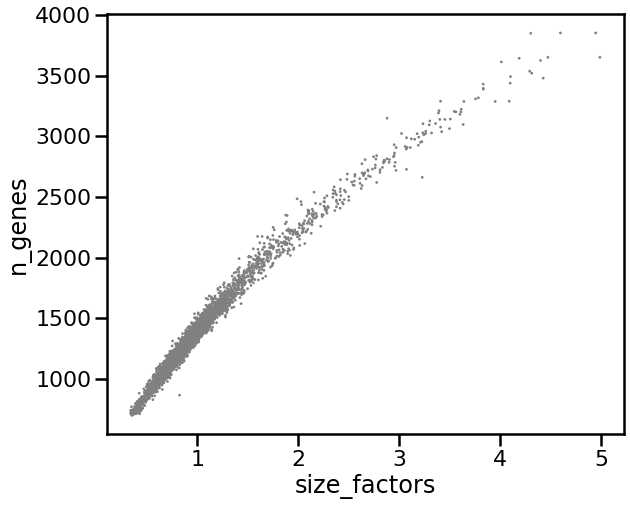

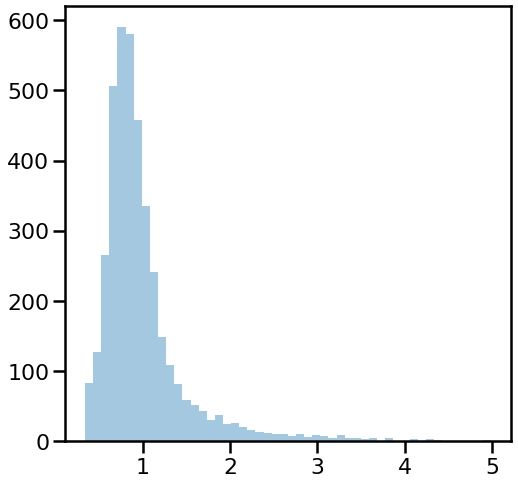

In [28]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [29]:
sc.pp.log1p(adata)

In [30]:
del adata_pp

## Batch correction

This dataset does not contain several batches, which is why we can skip this step. [Büttner et al., 2019](https://www.nature.com/articles/s41592-018-0254-1) compared the performance of several batch correction methods. For low-to-medium complexity datasets, ComBat performed best among the tested tools. ComBat is also available in `scanpy` (see `sc.pp.combat`).  

For high complexity data, especially when you encounter changes in cell type composition, consider to use a data integration method of your choice. We distinguish three different types, *i.e.* if the methods create a corrected data matrix (in feature space), an embedding or a knn-graph. Examples are:
1. feature space: MNN (`scanpy.external.pp.mnn_correct`), scanorama (integrates with scanpy), Seurat v3 (R based)
2. embedding: scVI (Python based), harmony (R based), scanorama
3. knn-graph: conos (R based), BBKNN (`scanpy.external.pp.bbknn`)

## Feature selection (Highly variable genes)

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software *CellRanger*. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

Compute highly variable genes and visualize.

In [82]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


In [59]:
adata

AnnData object with n_obs × n_vars = 4299 × 17038 
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'counts'

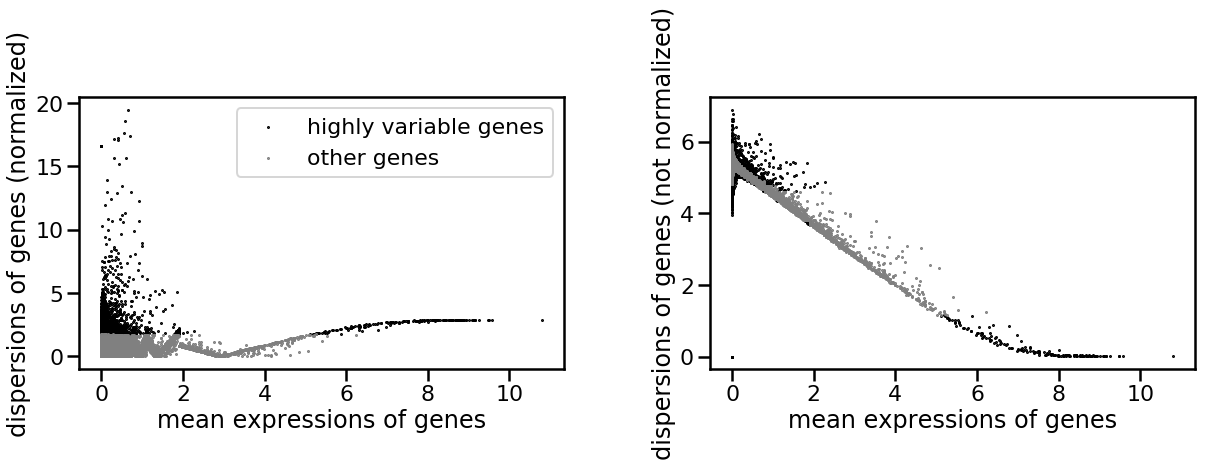

In [83]:
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the `adata.var['highly_variable']` field. The dataset now contains:

* count data in adata.raw
* log-scran normalized data in adata.X
* highly variable gene annotations in `adata.var['highly_variable']`


## Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

We will look at several visualizations to decide which visualization best represents the aspect of the data.

Compute the following embeddings: PCA, t-SNE, UMAP, diffusion map and force-directed graph. Please compute PCA first and compute nearest neighbors next. All other embeddings rely on this information. Visualize the embeddings and color by the total number of counts.

In [84]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:43)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99877554 0.9985625  0.99616045 0.9792915  0.96799517
     0.9654683  0.94439083 0.9075175  0.8967836  0.8940321  0.8724298
     0.8692635  0.8576591  0.83852136]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transitio

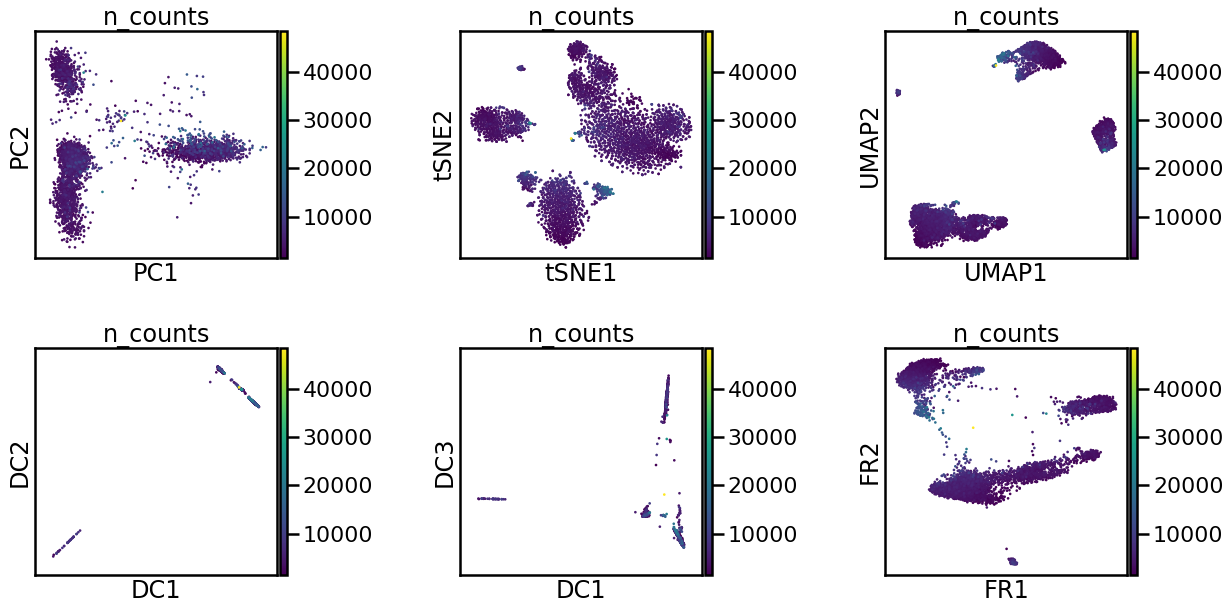

In [85]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
p13 = sc.pl.diffmap(adata, color='n_counts', components=['1,2'], ax=fig.add_subplot(fig_ind[3]),show=False)
p14 = sc.pl.diffmap(adata, color='n_counts', components=['1,3'], ax=fig.add_subplot(fig_ind[4]), show=False)
p15 = sc.pl.draw_graph(adata, color='n_counts', ax=fig.add_subplot(fig_ind[5]), show=False)

plt.show()

**PCA**:

* Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
* The plot shows a weak clustering of the data in two dimensions

**t-SNE**:

* Shows several distinct clusters with clear subcluster structure
* Connections between clusters are difficult to interpret visually

**UMAP**:

* Data points are spread out on the plot showing several clusters
* Connections between clusters also not visible (and not expected for PBMC data)

**Diffusion Maps**:

* Shows regions of higher density and a few disconnected cells in between
* Trajectories not visible (and not expected for PBMC data)
* Each diffusion component extracts heterogeneity in a different part of the data

**Graph**:

* Shows several clusters with substructure
* Lack of trajectories as expected

The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute. UMAP has furthermore been shown to more accurately display the structure in the data.

## Cell cycle scoring

Known sources of technical variation in the data have been investigated and corrected for (e.g. batch, count depth). A known source of biological variation that can explain the data is the cell cycle. Here, a gene list from [Macosko et al., Cell 161 (2015)](https://www.sciencedirect.com/science/article/pii/S0092867415005498) is used to score the cell cycle effect in the data and classify cells by cell cycle phase. The file can be found on the [single-cell-tutorial github repository of M. D. Lücken](https://github.com/theislab/single-cell-tutorial/blob/master/Macosko_cell_cycle_genes.txt).

Please note, that the gene list was generated for human HeLa cells.

In [35]:
cc_genes_file = './../Macosko_cell_cycle_genes.txt'

In [36]:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_hvg = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes_hvg = adata.var_names[np.in1d(adata.var_names, g2m_genes)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_hvg, g2m_genes=g2m_genes_hvg)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [37]:
print(len(s_genes_hvg))
print(len(g2m_genes_hvg))

89
102


In [38]:
adata.obs['phase'].value_counts()

G2M    3781
G1      139
S        52
Name: phase, dtype: int64

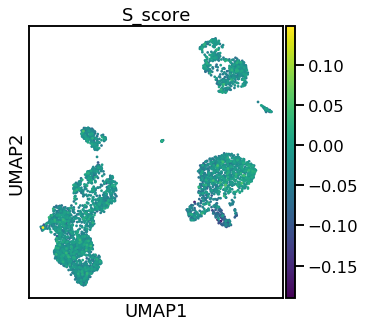

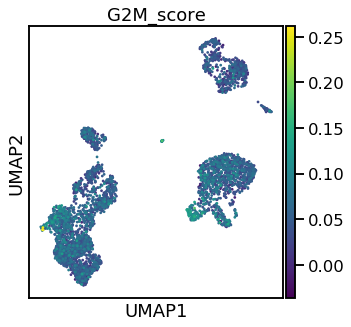

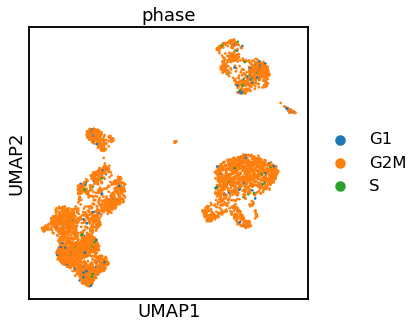

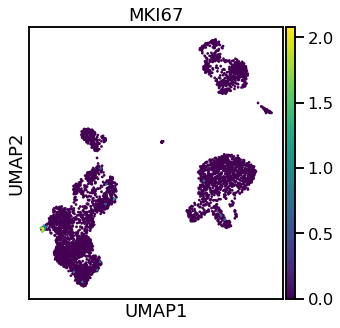

In [80]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['S_score'], use_raw=False)
sc.pl.umap(adata, color=['G2M_score'], use_raw=False)
sc.pl.umap(adata, color=['phase'], use_raw=False)
sc.pl.umap(adata, color='MKI67')

Apparently, all cells are assigned to the same proliferative cell cycle phase (G2M), but inspecting the interface marker MKI67 shows little evidence for proliferation. Potentially, we would need to adapt the cutoffs of the classification.

# Downstream analysis

## Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section).

Compute a `louvain` clustering with two different resolutions (`0.5` and `1`). Compare the clusterings in a table and visualize the clustering in an embedding. Optional: Compute a clustering with the `leiden` algorithm. 

In [86]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [87]:
pd.crosstab(adata.obs['louvain_r0.5'], adata.obs['louvain_r1'])

louvain_r1,0,1,2,3,4,5,6,7,8,9
louvain_r0.5,,,,,,,,,,
0,1001,0,0,25,409,286,0,0,0,0
1,0,920,0,0,0,0,0,6,0,0
2,0,0,0,568,2,3,168,0,0,0
3,0,2,609,0,0,0,0,0,0,0
4,0,0,0,0,0,28,0,0,119,0
5,0,0,0,0,0,0,0,116,0,0
6,0,0,0,0,0,0,0,0,0,37


In [96]:
rcParams['figure.figsize']=(5,5)

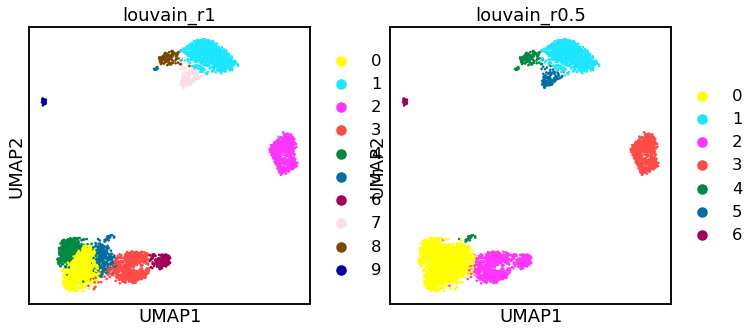

In [97]:
#sb.set_context('talk')
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
#sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

## Marker genes and cluster annotation 

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a *Welch t-test with overestimated variance* to be conservative. This is the default in `scanpy`. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

As we are using the relevant mouse gut atlas from the literature in this case study, there is no other reference atlas which we use to annotate the cells by automated annotation. Thus, we do not use scmap or garnett here.

Compute the differential expression profile for each cluster with `rank_genes_groups` and visualize the results.

In [91]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


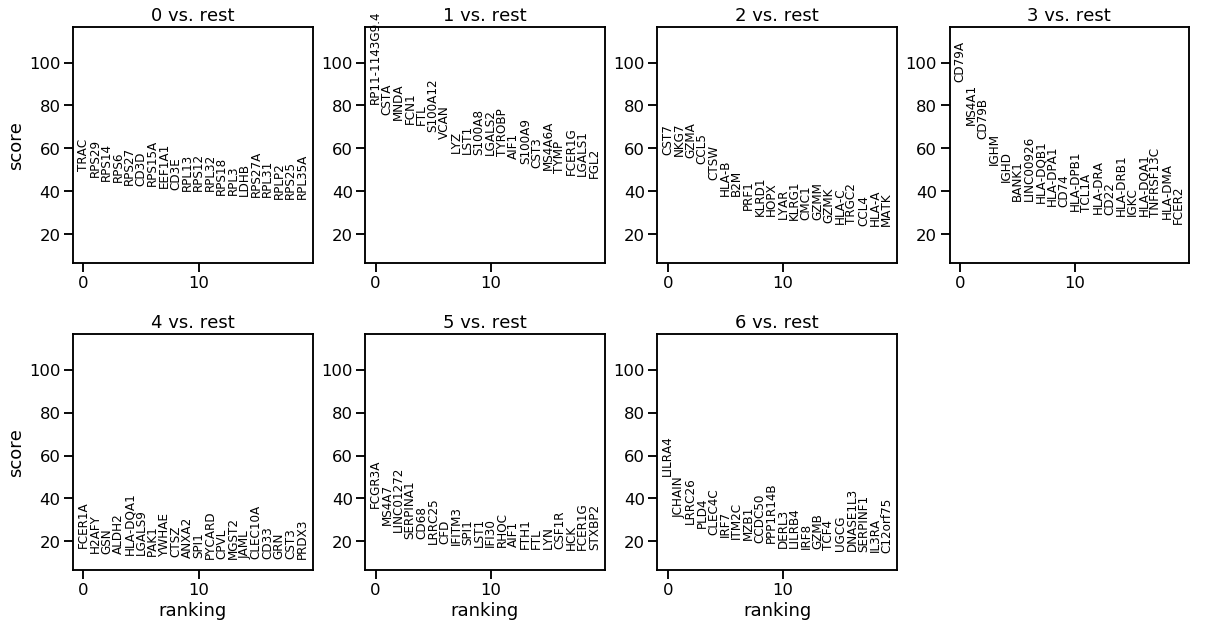

In [98]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12)

In [92]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


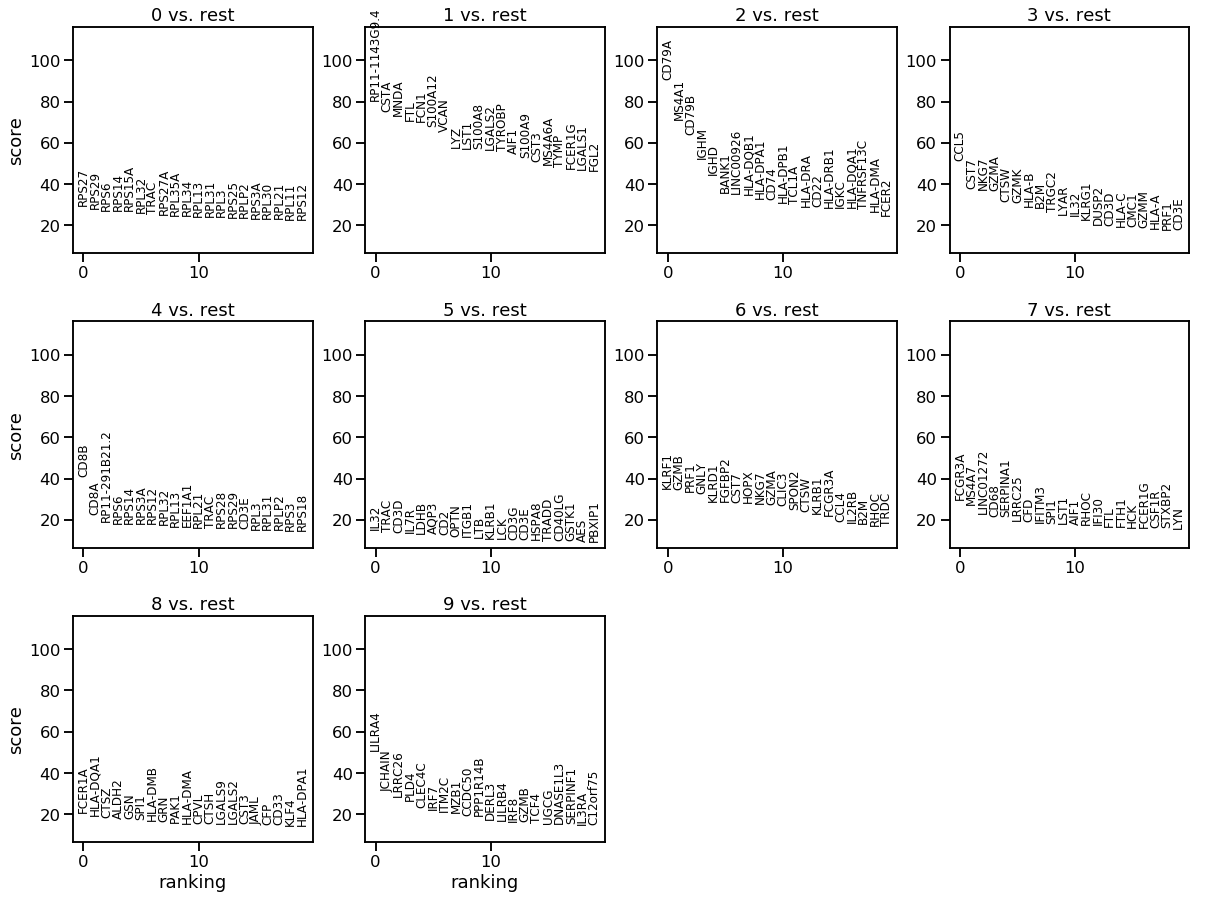

In [99]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', fontsize=12)

Here, we observe a considerable ribosomal proteins (*RPL* and *RPS*), which are part of the ribosomes. Thus, they are involved in mRNA translational processes. Usually, these genes are difficult to interpret.

When it comes to cluster annotation, we have to tap into prior knowledge of the cell type. Depending on the data set, this may involve extensive literature search. In the case of PBMCs, we may refer to several studies and single-cell RNA-sequencing data analysis tutorials to extract marker gene sets. 

The following list is extracted from the Seurat tutorial on PBMCs.


|Marker Gene|Cell Type|
|---------|-------|
|IL7R|CD4 T cells|
|CD14, LYZ|CD14+ Monocytes|
|MS4A1|B cells|
|CD8A|CD8 T cells|
|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|GNLY, NKG7|NK cells|
|FCER1A, CST3|Dendritic Cells|
|PPBP|Megakaryocytes|


Let us define a list of marker genes from literature.

In [100]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Annotate the clusters. You can use auxilliary plots like `matrixplot`, `dotplot`,`heatmap` or `violin` plots or coloring an embedding by the marker genes.

In [101]:
np.in1d(marker_genes, adata.var_names)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

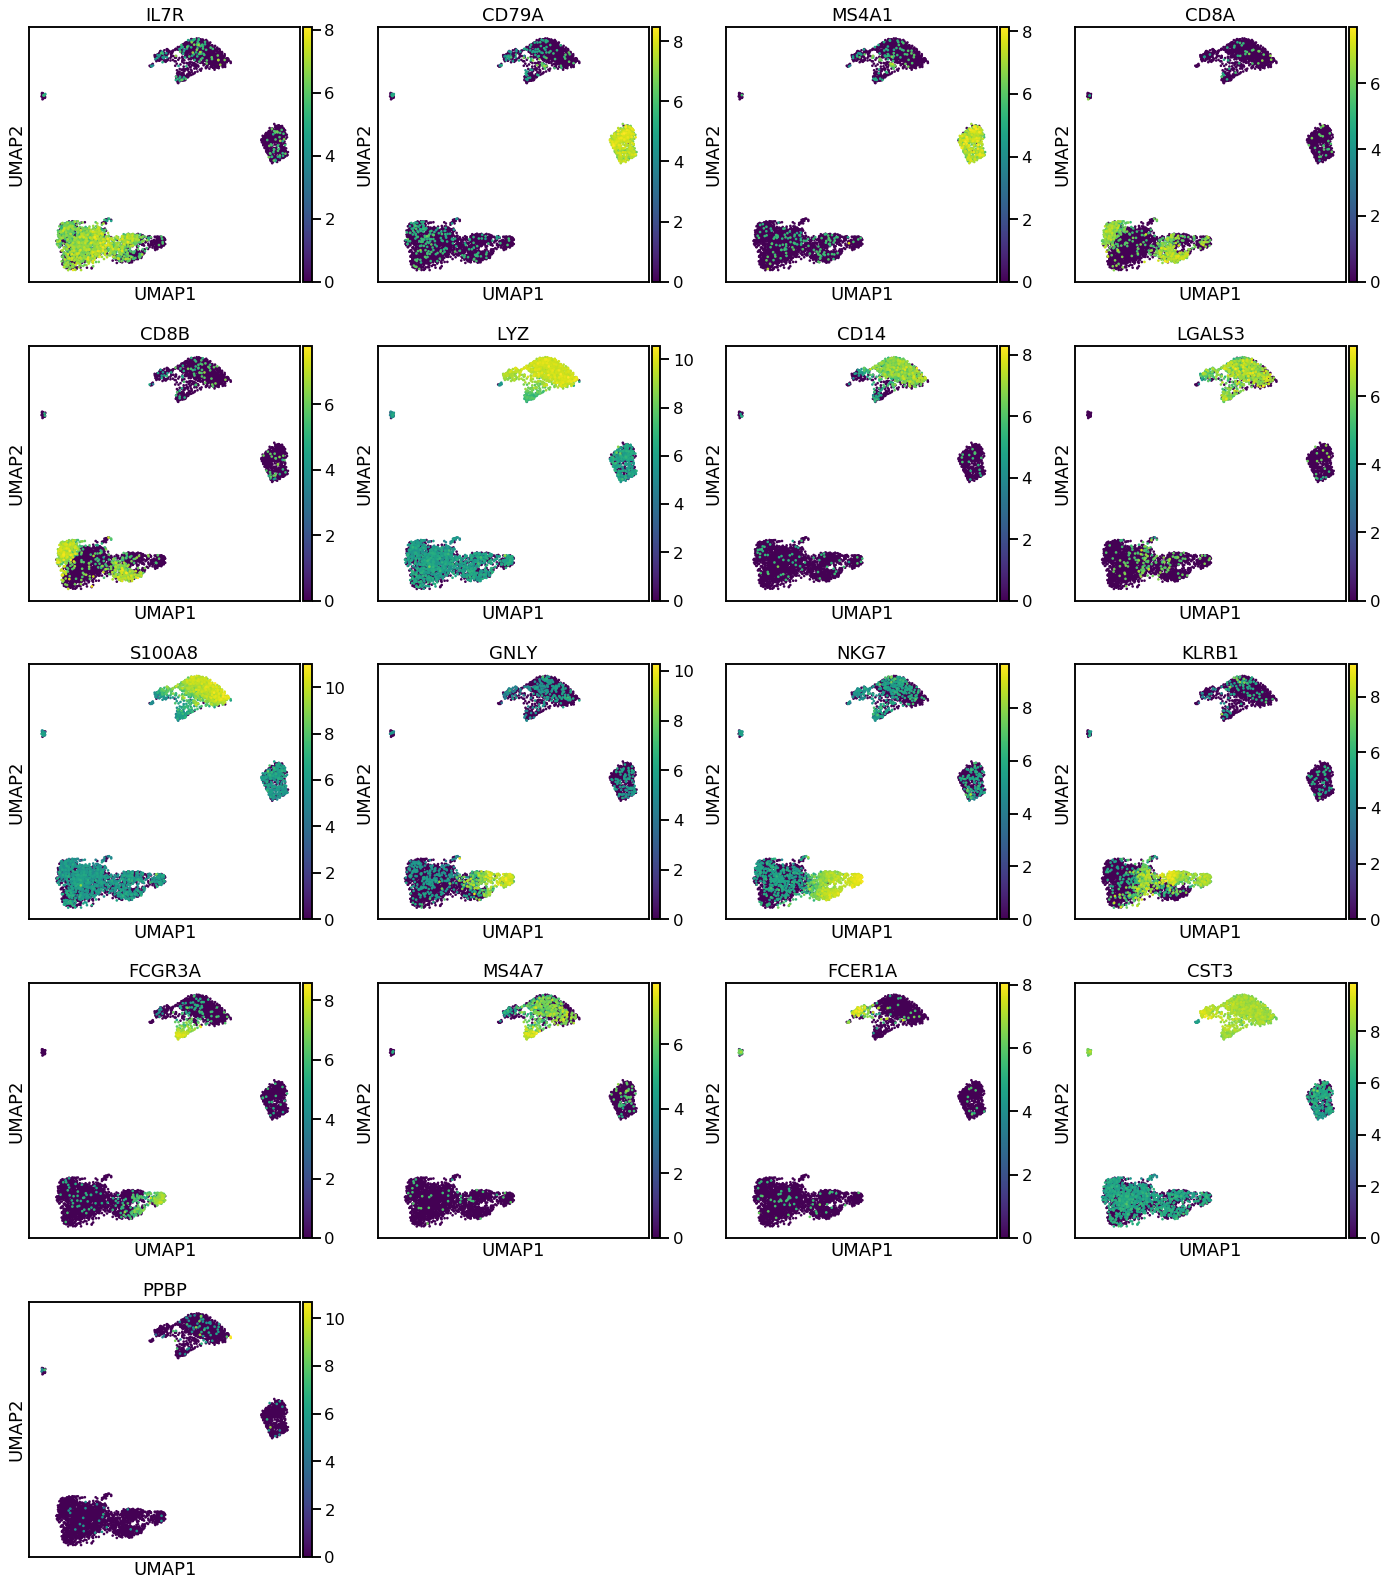

In [102]:
sc.pl.umap(adata=adata, color=marker_genes, use_raw=False)

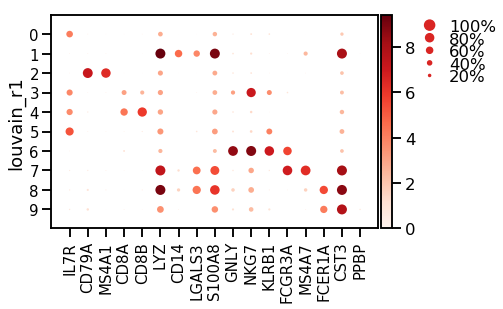

In [103]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain_r1', use_raw=False)

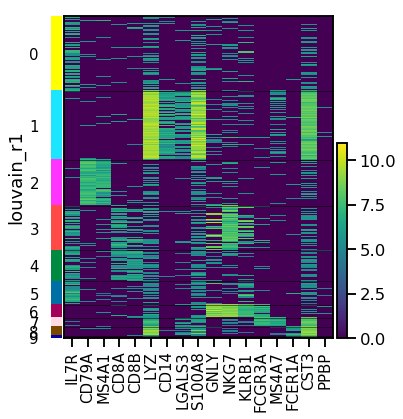

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 5.1, 0, 0.2])

In [104]:
sc.pl.heatmap(adata=adata, var_names=marker_genes,
              groupby='louvain_r1', use_raw=False, vmin=0)

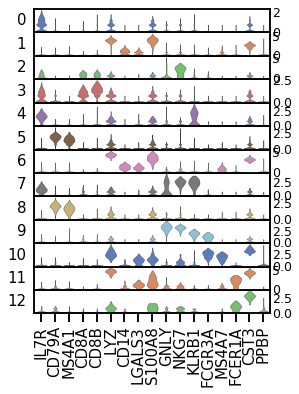

In [52]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r1', use_raw=False)

Annotate clusters and create a new covariate.


|Cluster ID|Marker Gene|Cell Type|
|---------|-------|-------|
|0,4|IL7R|CD4 T cells|
|1,6|CD14, LYZ|CD14+ Monocytes|
|5,8|MS4A1|B cells|
|2,3|CD8A|CD8 T cells|
|10|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|7,9|GNLY, NKG7|NK cells|
|11,12|FCER1A, CST3|Dendritic Cells|
|none|PPBP|Megakaryocytes|

Use the `pandas` data frame functionality to rename your clusters and visualize your annotation.

In [105]:
adata.obs.columns

Index(['n_genes', 'n_counts', 'louvain_r1', 'louvain_r0.5'], dtype='object')

In [111]:
adata.obs['annotated'] = adata.obs['louvain_r1'].cat.add_categories(['CD4 T cells', 
                        'CD14+ Monocytes', 'B cells', 'CD8 T cells', 
                        'FCGR3A+ Monocytes', 'NK cells', 'Monocytes', 'unhealthy cells'])

In [109]:
adata.obs['annotated']

0
AAACCTGAGAAGGCCT-1    1
AAACCTGAGACAGACC-1    1
AAACCTGAGATAGTCA-1    1
AAACCTGAGCGCCTCA-1    3
AAACCTGAGGCATGGT-1    0
AAACCTGCAAGGTTCT-1    3
AAACCTGCAGGATTGG-1    9
AAACCTGCAGGCGATA-1    8
AAACCTGCATCCCATC-1    2
AAACCTGCATGAAGTA-1    1
AAACCTGGTACATCCA-1    2
AAACCTGGTGCGGTAA-1    4
AAACCTGTCGTGGTCG-1    0
AAACCTGTCTCTGCTG-1    5
AAACGGGAGCGGCTTC-1    8
AAACGGGAGGCTAGCA-1    4
AAACGGGAGTGTCCAT-1    4
AAACGGGGTCTTCTCG-1    1
AAACGGGGTGGACGAT-1    3
AAACGGGGTTTGCATG-1    1
AAACGGGTCTGGGCCA-1    4
AAACGGGTCTGGTATG-1    4
AAAGATGAGACATAAC-1    4
AAAGATGGTCCCTACT-1    2
AAAGATGTCCGAATGT-1    4
AAAGATGTCTGGTTCC-1    1
AAAGCAAAGTGTCCAT-1    9
AAAGCAACACCGAAAG-1    4
AAAGCAAGTAAACACA-1    6
AAAGCAAGTCAAGCGA-1    0
                     ..
TTTCCTCAGTGACTCT-1    8
TTTCCTCAGTTAGGTA-1    3
TTTCCTCCAAATACAG-1    1
TTTCCTCCAATCTACG-1    5
TTTCCTCCATAGGATA-1    1
TTTCCTCGTGGACGAT-1    0
TTTCCTCGTTACCGAT-1    1
TTTCCTCTCACAATGC-1    4
TTTCCTCTCAGAGACG-1    3
TTTCCTCTCCGAACGC-1    6
TTTCCTCTCCGCGC

In [112]:
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['0'])] = 'unhealthy cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['5'])] = 'CD4 T cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['1'])] = 'CD14+ Monocytes'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['2'])] = 'B cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3', '4'])] = 'CD8 T cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['7'])] = 'FCGR3A+ Monocytes'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['6'])] = 'NK cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['8', '9'])] = 'Monocytes'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [113]:
adata.obs['annotated'].value_counts()

CD8 T cells          1004
unhealthy cells      1001
CD14+ Monocytes       922
B cells               609
CD4 T cells           317
NK cells              168
Monocytes             156
FCGR3A+ Monocytes     122
Name: annotated, dtype: int64

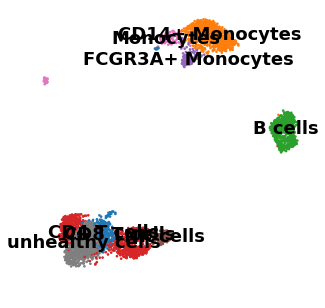

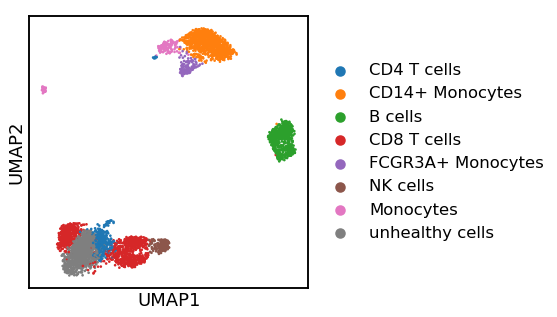

In [114]:
sc.pl.umap(adata, color='annotated', legend_loc='on data', title='', frameon=False)
sc.pl.umap(adata, color='annotated',  title='', frameon=True)

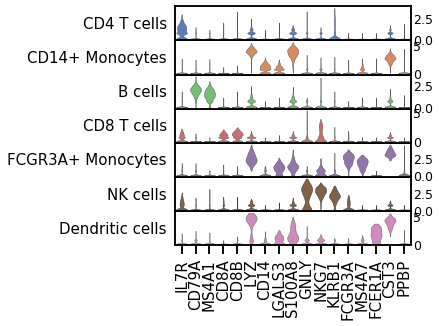

In [82]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='annotated', use_raw=False)

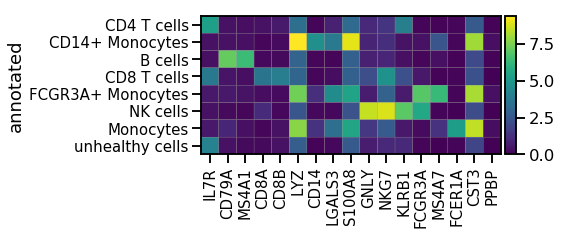

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[5.44, 0, 0.2])

In [115]:
sc.pl.matrixplot(adata, marker_genes, groupby='annotated', use_raw=False, vmin=0)

Let us determine the differences in the B cell clusters by differential expression.

In [84]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['5'], reference='8', rankby_abs=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


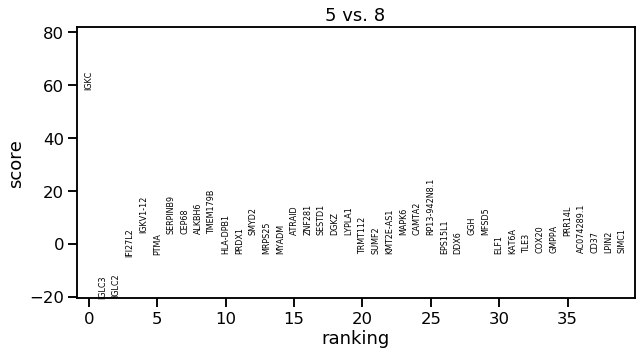

In [85]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata, size=10, n_genes=40)

/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


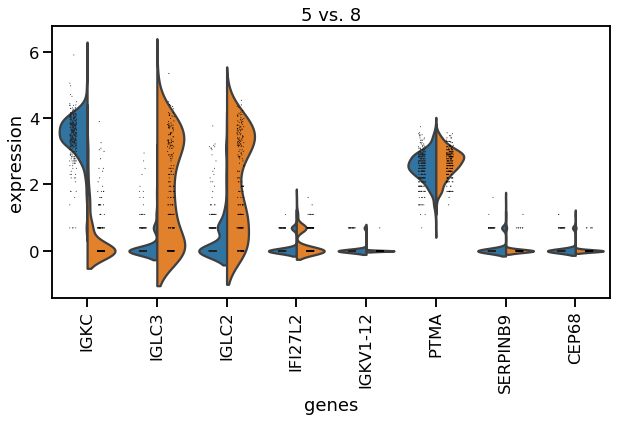

In [86]:
sc.pl.rank_genes_groups_violin(adata, groups='5', n_genes=8, use_raw=False)

Here, the B cells have a distinct *IGKC* positive subpopulation. The *IGKC* gene was found to be predictive for cancer prognosis.

### Compute a PAGA for PBMCs

We aim to find relations between the respective cell types based on the knn graph with partition-based graph abstraction (PAGA). 

Compute PAGA on the cluster annotation and plot the graph (note: use the plot function `paga_compare`).

In [87]:
sc.tl.paga(adata = adata, groups='annotated')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


--> added 'pos', the PAGA positions (adata.uns['paga'])


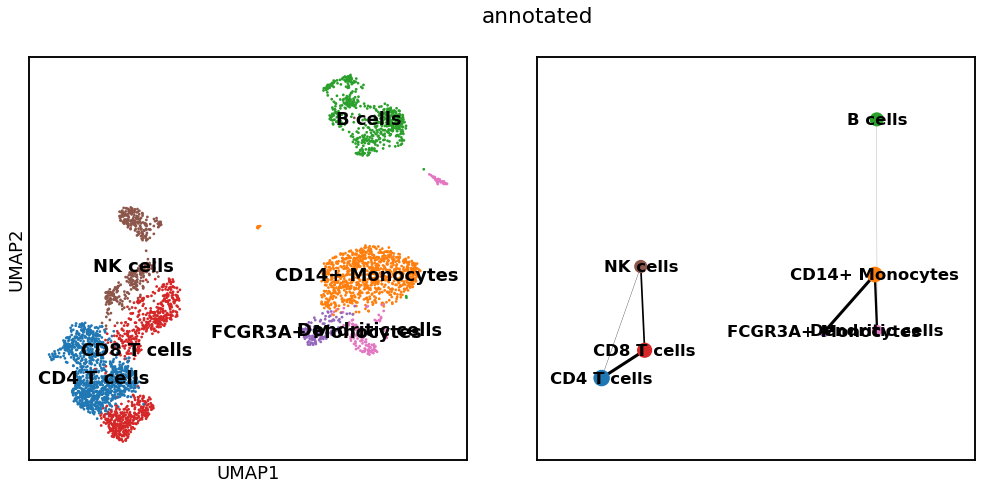

In [88]:
rcParams['figure.figsize']=(7,7)
sc.pl.paga_compare(adata = adata, basis='umap', frameon=True)

## Pseudotime on Monocytes

In this section, we want to explore a potential transition of CD14+ and FCGR3A+ Monocytes.

Select the monocytes.

In [89]:
adata_mono = adata[np.in1d(adata.obs['annotated'], 
                           ['CD14+ Monocytes', 'FCGR3A+ Monocytes'])].copy()

In [90]:
adata_mono

AnnData object with n_obs × n_vars = 1015 × 12220 
    obs: 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'annotated'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'diffmap_evals', 'draw_graph', 'phase_colors', 'louvain', 'louvain_r1_colors', 'louvain_r0.5_colors', 'rank_genes_r0.5', 'rank_genes_r1', 'annotated_colors', 'rank_genes_groups', 'paga', 'annotated_sizes'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'counts'

Compute a diffusion pseudotime (DPT). Note: Fix a root cell as `adata.uns['iroot']` first. Visualize the pseudotime on the embedding. Compute the differentially expressed genes between the two subgroups and visualize the expression of 20 top differentially expressed genes along pseudotime.

In [91]:
sc.tl.pca(adata_mono, svd_solver='arpack')
sc.pp.neighbors(adata_mono)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


Convert UMAP indices to arrays.

In [92]:
umap_0 = [term[0] for term in adata_mono.obsm['X_umap']]
umap_1 = [term[1] for term in adata_mono.obsm['X_umap']]

Set root cell to the cell with the smallest value in the second UMAP component and compute DPT.

In [93]:
adata_mono.uns['iroot'] = np.flatnonzero(umap_1== min(umap_1))[0]
sc.tl.dpt(adata = adata_mono)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Visualise DPT on a UMAP and on a diffusion map.

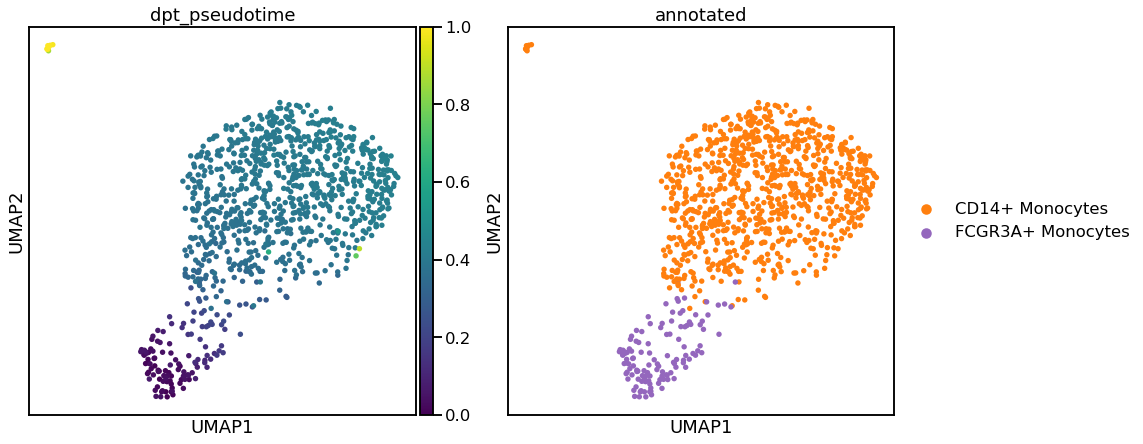

In [94]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_mono, color=['dpt_pseudotime', 'annotated'])

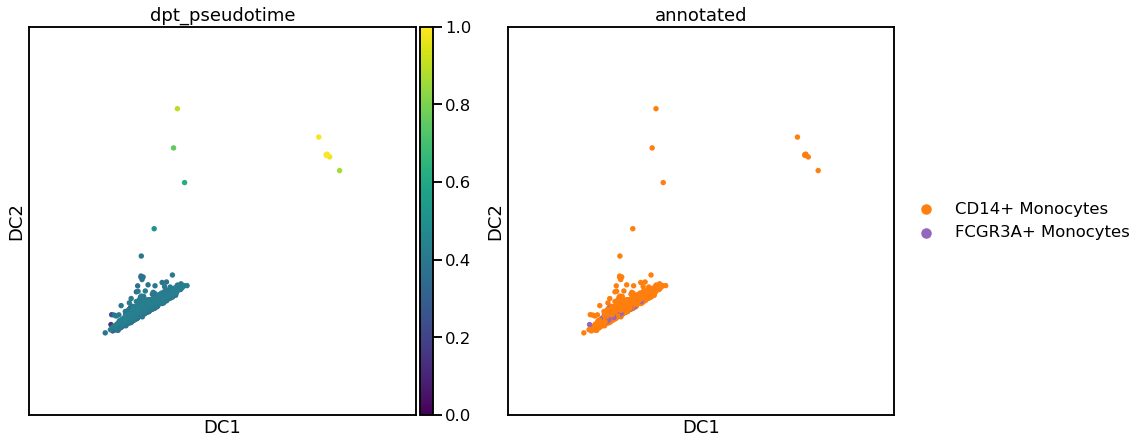

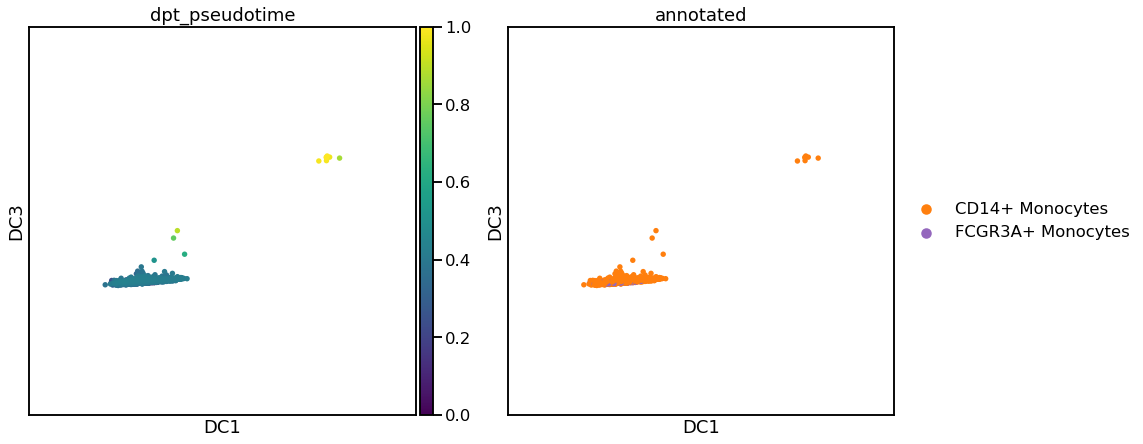

In [95]:
rcParams['figure.figsize']=(7,7)
sc.pl.diffmap(adata_mono, color=['dpt_pseudotime', 'annotated'], components=['1,2'])
sc.pl.diffmap(adata_mono, color=['dpt_pseudotime', 'annotated'], components=['1,3'])

Run a differential test on the two groups of monocytes in order to determine characteristic genes.  

In [96]:
sc.tl.rank_genes_groups(adata_mono, groupby='annotated', 
                        groups= ['FCGR3A+ Monocytes'], reference='CD14+ Monocytes', rankby_abs=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


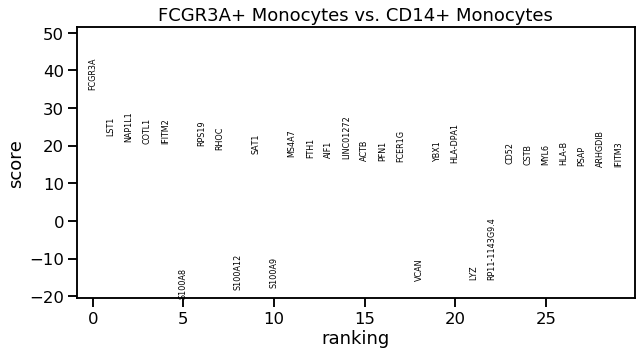

In [99]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata_mono, size=10, n_genes=30)

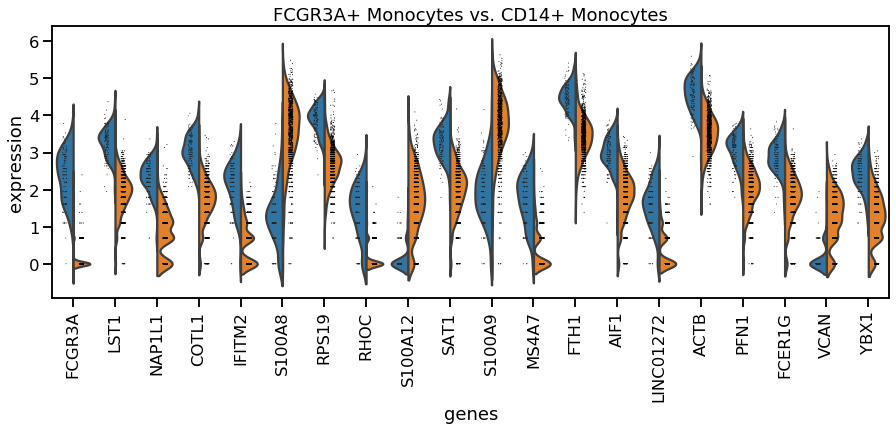

In [100]:
rcParams['figure.figsize']= (15,5)
sc.pl.rank_genes_groups_violin(adata_mono, use_raw=False)

In [101]:
mono_genes = [idx[1][0] for idx in enumerate(adata_mono.uns['rank_genes_groups']['names'])]


In order to visualise the gene expression along pseudotime, we have to compute PAGA for the two groups of monocytes.

In [102]:
sc.tl.paga(adata_mono, groups='annotated')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


/home/icb/daniel.strobl/miniconda3/envs/benchmarking_data_integration_dev/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


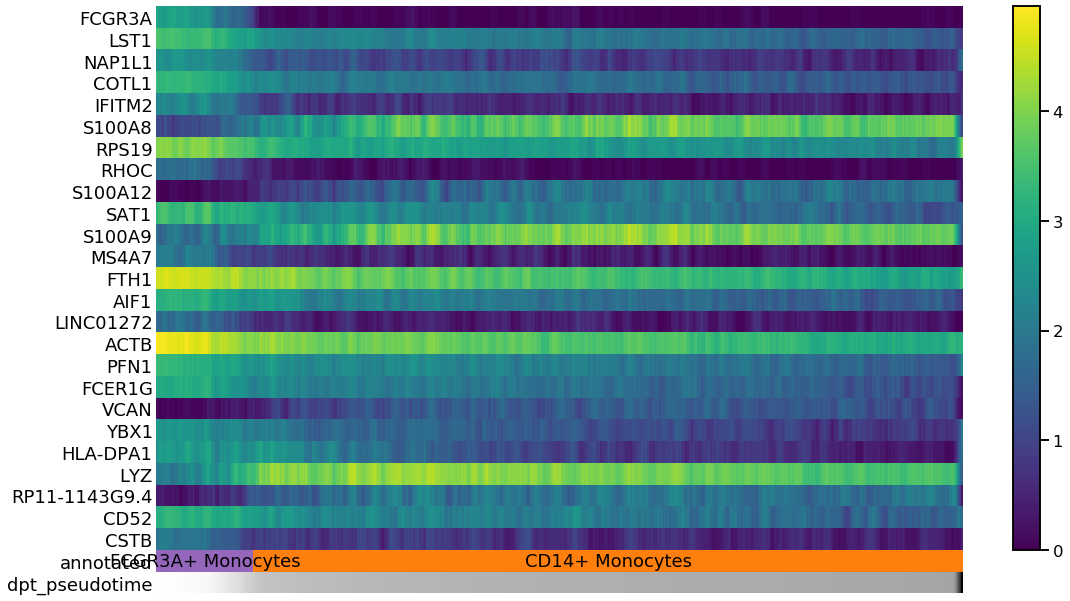

In [103]:
rcParams['figure.figsize']=(20,10)
sc.pl.paga_path(adata_mono, nodes=['FCGR3A+ Monocytes', 'CD14+ Monocytes'], 
                keys=mono_genes[:25],n_avg=10, use_raw=False)